In [1]:
import torch
from fastai.text import *
from Transformer import Transformer as my_transformer

## Code for preprocessing data and Bleu-metric

In [2]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [3]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [4]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [5]:
path = Config().data_path()

In [6]:
path = Config().data_path()/'giga-fren'/'giga-fren'

In [7]:
data = load_data(path)

In [8]:
data.show_batch()

text,target
"xxbos quel est le risque de contracter la maladie x après avoir été exposé à des facteurs de risque environnementaux , comme des polluants dans la zone de résidence ?","xxbos what is the risk of developing disease x after exposure to environmental risk factors , such as pollutants in the area of residence ?"
xxbos quelle importance votre organisation xxunk - t - elle au traitement non discriminatoire et égal des immigrés comme condition préalable au développement de la diversité culturelle en europe ?,"xxbos which importance does your organisation attach to a non - discriminatory , equal treatment of immigrants as a xxunk for the development of cultural diversity in european societies ?"
xxbos quelles sont vos opinions sur le sujet et quelle est la meilleure façon de faire xxunk un concept pour arriver à une technologie viable sur le plan commercial ?,xxbos what are some of your thoughts on this subject and best way of moving from an idea to a commercially viable technology ?
xxbos qu'en est - il dans le cas de la xxunk in vitro où des centaines de milliers d'entre eux sont xxunk sans être xxunk à aucun projet parental ?,xxbos what about cases of xxunk treatment where hundreds of thousands of these embryos are frozen without being assigned to a subsequent pregnancy ?
xxbos quelles conditions particulières doivent être remplies pendant l’examen préliminaire international en ce qui concerne les xxunk des séquences de nucléotides ou d’acides aminés ou les tableaux y relatifs ?,xxbos what special requirements apply during the international preliminary examination to nucleotide and / or amino acid sequence listings and / or tables related thereto ?


## Shifting

Add a transformation function that add shifted targets to the inputs of the model. This is a copy of an identical preprocessing done in fastai's transformer notebook provided with the 2019 NLP course. 


In [9]:
v = data.vocab
v.stoi['xxpad']

1

In [10]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [11]:
# do not run this cell twice
data.add_tfm(shift_tfm)

In [12]:
data.x[0].text

'xxbos qu’est - ce que la lumière ?'

In [13]:
traindl = iter(data.train_dl)

In [14]:
type(next(traindl)), len(next(traindl))

(tuple, 2)

In [15]:
inp_batch = next(traindl)
inp_batch[0]

[tensor([[    2,    27,   580,  5212,    11,    74,    14,    45,    10,  1337,
            188,     9,     1],
         [    2,    24,    20,    12,   104,    25,    72,  2314,    11,  3821,
           1617,     9,     1],
         [    2,    33,    22,    11,    28,    19,    63,   183,    22,    51,
            562,     9,     1],
         [    2,    19,   134,    11,    29,    52,    21,  4197,    12,  6547,
           3763,     9,     1],
         [    2,    65,    11,    28,    23,  1147,    39,   111,   111,     0,
           1236,     9,     1],
         [    2,    27,   433,    10,    87,   223,  3352,    66,    11,    43,
           5233,     9,     1],
         [    2,    27,    20,    12,  3532,    12,    45,     0,    10,    46,
           1484,     9,     1],
         [    2,    19,    59,  2930,    11,    29,    51,    28,    72,  7861,
             48,     9,     1],
         [    2,    23,    40,    13,   360,    10,   600,    12,   104,    25,
            779,     9, 

## Loading Embeddings

In [16]:
model_path = Config().model_path()

In [17]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

## Loss and accuracy functions

This is copy of fastai's implementation of the bleu metric. 

In [18]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [19]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [20]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [21]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [22]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [23]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb).cpu()
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [24]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

## My Transformer

In [25]:
num_heads = 8
transformer = my_transformer(emb_enc.weight.data, emb_dec.weight.data, num_heads = num_heads)
transformer = transformer.cuda()
transformer

Transformer(
  (enc_emb): Embedding(11336, 300, padding_idx=1)
  (drop_input): Dropout(p=0.1, inplace=False)
  (encoder): encoder_stack(
    (stack): Sequential(
      (0): encoder(
        (mul_h_attn): multi_head_attn(
          (heads): ModuleList(
            (0): self_attention(
              (WQ): Linear(in_features=300, out_features=37, bias=False)
              (WK): Linear(in_features=300, out_features=37, bias=False)
              (WV): Linear(in_features=300, out_features=37, bias=False)
            )
            (1): self_attention(
              (WQ): Linear(in_features=300, out_features=37, bias=False)
              (WK): Linear(in_features=300, out_features=37, bias=False)
              (WV): Linear(in_features=300, out_features=37, bias=False)
            )
            (2): self_attention(
              (WQ): Linear(in_features=300, out_features=37, bias=False)
              (WK): Linear(in_features=300, out_features=37, bias=False)
              (WV): Linear(in_feature

In [26]:
next(iter(transformer.parameters())).is_cuda

True

In [27]:
# create a learner based on the transformer
learn = Learner(data, transformer, loss_func=seq2seq_loss, 
                metrics=[seq2seq_acc, CorpusBLEU(len(data.train_ds.y.vocab.itos))])

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


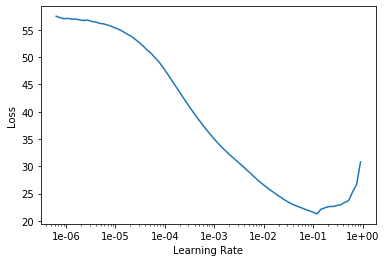

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8, 5e-4, div_factor = 5)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.862966,3.173168,0.563059,0.421688,01:16
1,2.452380,2.590700,0.608266,0.450832,01:17
2,2.093873,2.323136,0.640868,0.465310,01:17
3,1.837251,2.007134,0.666379,0.480771,01:16
4,1.689504,1.770551,0.695614,0.511168,01:17
5,1.510879,1.622698,0.714669,0.527113,01:16
6,1.340519,1.554478,0.724518,0.539455,01:15
7,1.275086,1.542626,0.726145,0.540960,01:17


In [30]:
learn.fit_one_cycle(8, 5e-4, div_factor = 5)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.262238,1.541084,0.725805,0.540532,01:16
1,1.323489,1.536113,0.727106,0.543081,01:16
2,1.239091,1.467378,0.734355,0.550555,01:17
3,1.081250,1.387838,0.747349,0.565355,01:18
4,0.918348,1.337473,0.757211,0.578829,01:17
5,0.775400,1.288458,0.764857,0.589193,01:17
6,0.704190,1.285699,0.769347,0.595464,01:18
7,0.633310,1.286594,0.770419,0.597021,01:16


In [31]:
inputs, targets, outputs = get_predictions(learn)

In [32]:
inputs[10].text,targets[10].text,outputs[10].text

('xxbos quelles méthodes a - t - on trouvées particulièrement efficaces pour consulter le public et les parties intéressées sur la protection des renseignements personnels reliés à la santé ?',
 'xxbos what approaches have been found particularly effective in consulting with the public and stakeholders on the protection of personal health information ?',
 'xxbos what methods have been found particularly effective in addressing the the public and stakeholders on the protection of personal health information ?')

In [33]:
inputs[700].text,targets[700].text,outputs[700].text

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the authority to change the regulations and control measures measures ? to regulations and regulations of ?')

In [34]:
inputs[701].text,targets[701].text,outputs[701].text

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are to them views beliefs beliefs transparency and accountability ?')

In [35]:
inputs[2500].text,targets[2500].text,outputs[2500].text

('xxbos de quoi l’afrique a - t - elle vraiment besoin pour se sortir de la pauvreté ?',
 'xxbos what does africa really need to pull itself out of poverty ?',
 'xxbos what does africa really need to pull out out of poverty ?')

In [36]:
inputs[4002].text,targets[4002].text,outputs[4002].text

('xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?',
 'xxbos what resources exist in your community that would promote recovery ?',
 'xxbos what resources does in your community that would help healing ?')

## Predictions without inputing ground truth labels

In [37]:
def get_predictions2(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model.predict(xb[0].cuda()).cpu()
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [52]:
xb,yb = next(iter(learn.dl(DatasetType.Valid)))

In [53]:
xb[0].shape

torch.Size([64, 30])

In [54]:
out = learn.model.predict(xb[0].cuda()).cpu()
out.shape

torch.Size([64, 30, 8144])

In [58]:
out_ind = out.argmax(2)
out_ind.shape

torch.Size([64, 30])

In [59]:
out_ind

tensor([[  9,   1,   1,  ...,   1,   1,   1],
        [  9,   1,   1,  ...,   1,   1,   1],
        [ 14,  11,  44,  ...,   1,   1,   1],
        ...,
        [ 13, 307,   9,  ...,   1,   1,   1],
        [  9,   1,   1,  ...,   1,   1,   1],
        [ 25, 129,   0,  ...,   1,   1,   1]], grad_fn=<NotImplemented>)

<font color = green> Note that most of the prediction are made up of just the padding token. Thus the predicitons are quite bad :( </font>

In [42]:
inputs, targets, outputs = get_predictions2(learn)

In [62]:
outputs

[Text [9],
 Text [9],
 Text [  14   11   44  274   43 2873   82   50 1288   27  704  795   13 4302    9],
 Text [9],
 Text [  13  617  131   14   60  131   17   10 1125   14   60  131   17  617  131    9],
 Text [  14   11   57   37   76  782  782  351 1206   13   10  918   14   10  918   12   76  782    9],
 Text [9],
 Text [9],
 Text [103   9],
 Text [9],
 Text [9],
 Text [9],
 Text [9],
 Text [ 13  24  90  55  10 264  17 216  13 142  31  10 134  12 496   0 190   9],
 Text [9],
 Text [9],
 Text [9],
 Text [  18 2559   14 2438   18   14 2438   18   14 2438   18   14 2438   18   14 2438   18   14 2438    9],
 Text [9],
 Text [9],
 Text [ 14  73  36  42  24 430  13 417  20  10   0  12  10 393  14  73  36  42  24   0   9],
 Text [9],
 Text [13 46  9],
 Text [9],
 Text [177   9],
 Text [9],
 Text [9],
 Text [9],
 Text [ 309   25  325  337 4457   13  161   31   10 1883   15    0    9],
 Text [9],
 Text [ 13  84  14 181  13  24   0  13 805  84  83  60   9],
 Text [9],
 Text [ 13 142  31  83

<font color = green> The get_predictions2 function creates the outputs by stripping away the padding token at the end of the predictions. We thus see that most of the sequences consists of just the token with index 9. This is the index for the question-mark. </font>

In [65]:
data.y.vocab.itos[9]

'?'

In [63]:
inputs[2].text,targets[2].text,outputs[2].text

('xxbos que se passerait - il … … si les voyageurs pouvaient renouveler leur passeport en direct et si les entreprises pouvaient remplir les formalités xxunk à partir d’internet ?',
 'xxbos what if … … travellers could renew their passports on - line , and businesses could use internet - based customs clearance ?',
 'and what would happen if travellers could not re - free travel to innovision ?')

In [51]:
outputs[10]

Text [9]

In [43]:
inputs[10].text,targets[10].text,outputs[10].text

('xxbos quelles méthodes a - t - on trouvées particulièrement efficaces pour consulter le public et les parties intéressées sur la protection des renseignements personnels reliés à la santé ?',
 'xxbos what approaches have been found particularly effective in consulting with the public and stakeholders on the protection of personal health information ?',
 '?')

In [44]:
inputs[700].text,targets[700].text,outputs[700].text

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'and what measures are there ?')

In [45]:
inputs[701].text,targets[701].text,outputs[701].text

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 '?')

In [46]:
inputs[2500].text,targets[2500].text,outputs[2500].text

('xxbos de quoi l’afrique a - t - elle vraiment besoin pour se sortir de la pauvreté ?',
 'xxbos what does africa really need to pull itself out of poverty ?',
 '?')

In [47]:
inputs[4002].text,targets[4002].text,outputs[4002].text

('xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?',
 'xxbos what resources exist in your community that would promote recovery ?',
 '?')

<font color = green> Without inputing the true targets for decoder's input, this does not seems to perform very well on translation. Then how come it is considered so good in general?? </font> 